WARNING  - This function will be deprecated, instantiate the concrete classes instead: `VOCBBoxParser`, `VOCMaskParser` | icevision.parsers.voc_parser:voc:17


  0%|          | 0/500 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/400 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 315) - Clipping bbox xmax from 513 to image width 499 (Before: <BBox (xmin:495, ymin:35, xmax:513, ymax:61)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 126) - Clipping bbox xmax from 501 to image width 499 (Before: <BBox (xmin:482, ymin:0, xmax:501, ymax:15)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 126) - Clipping bbox xmax from 527 to image width 499 (Before: <BBox (xmin:508, ymin:26, xmax:527, ymax:53)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-FAIL - (record_id: 126) - Cannot auto-fix coordinates: <BBox (xmin:508, ymin:26, xmax:499, ymax:53)>
	x_min:508 is greater than or equal to x_max:499 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: 126) Removed annotation with index: 4, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:45
AUTOFIX-SUCCESS - (record_id: 411) - Clipping bbox xmax from 515 to image width 499 

  0%|          | 0/100 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 140) - Clipping bbox xmax from 501 to image width 499 (Before: <BBox (xmin:483, ymin:29, xmax:501, ymax:51)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 366) - Clipping bbox xmax from 509 to image width 499 (Before: <BBox (xmin:491, ymin:22, xmax:509, ymax:48)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 76) - Clipping bbox xmax from 506 to image width 499 (Before: <BBox (xmin:488, ymin:30, xmax:506, ymax:58)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 430) - Clipping bbox xmax from 516 to image width 499 (Before: <BBox (xmin:497, ymin:24, xmax:516, ymax:55)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 38) - Clipping bbox xmax from 516 to image width 499 (Before: <BBox (xmin:497, ymin:30, xmax:516, ymax:57)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 494) - Clipping bbox xmax from 514 to imag

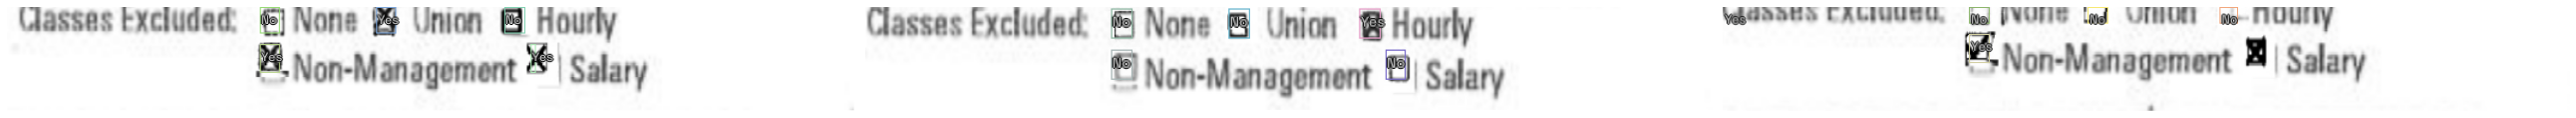

In [1]:
from icevision.all import *
data_dir = Path('train')

images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'
class_map = ClassMap(['YES','NO'])
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)
show_records(train_records[:3], ncols=3, class_map=class_map)

In [2]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)


In [6]:
model_type = models.torchvision.retinanet
backbone = model_type.backbones.resnet50_fpn(pretrained=True)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

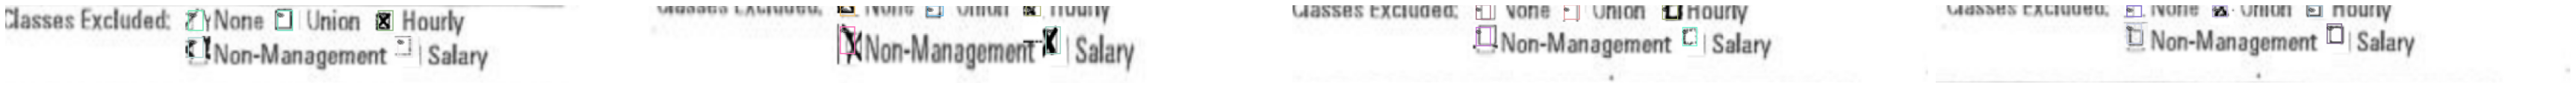

In [9]:
train_dl = model_type.train_dl(train_ds, batch_size=4, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=4, num_workers=4, shuffle=False)
model_type.show_batch(first(valid_dl), ncols=4)

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=5.248074739938602e-05)

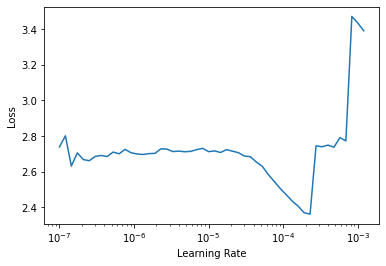

In [11]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
learn.lr_find()

In [37]:
learn.fine_tune(30, 1e-4, freeze_epochs=3)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.265562,0.369653,0.424616,00:13
1,0.295264,0.394983,0.406705,00:13
2,0.300230,0.387064,0.396909,00:13


epoch,train_loss,valid_loss,COCOMetric,time
0,0.238563,0.349370,0.469083,00:18
1,0.230805,0.340445,0.470377,00:18
2,0.214075,0.334117,0.512962,00:18
3,0.206397,0.330011,0.503804,00:18
4,0.209694,0.345512,0.486196,00:18
5,0.209871,0.358399,0.501605,00:18
6,0.214734,0.382322,0.466308,00:18
7,0.212904,0.521220,0.480652,00:18
8,0.194025,0.326189,0.538364,00:18
9,0.184452,0.349552,0.522206,00:18


In [38]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, detection_threshold=0.35, keep_images=True)

  0%|          | 0/100 [00:00<?, ?it/s]

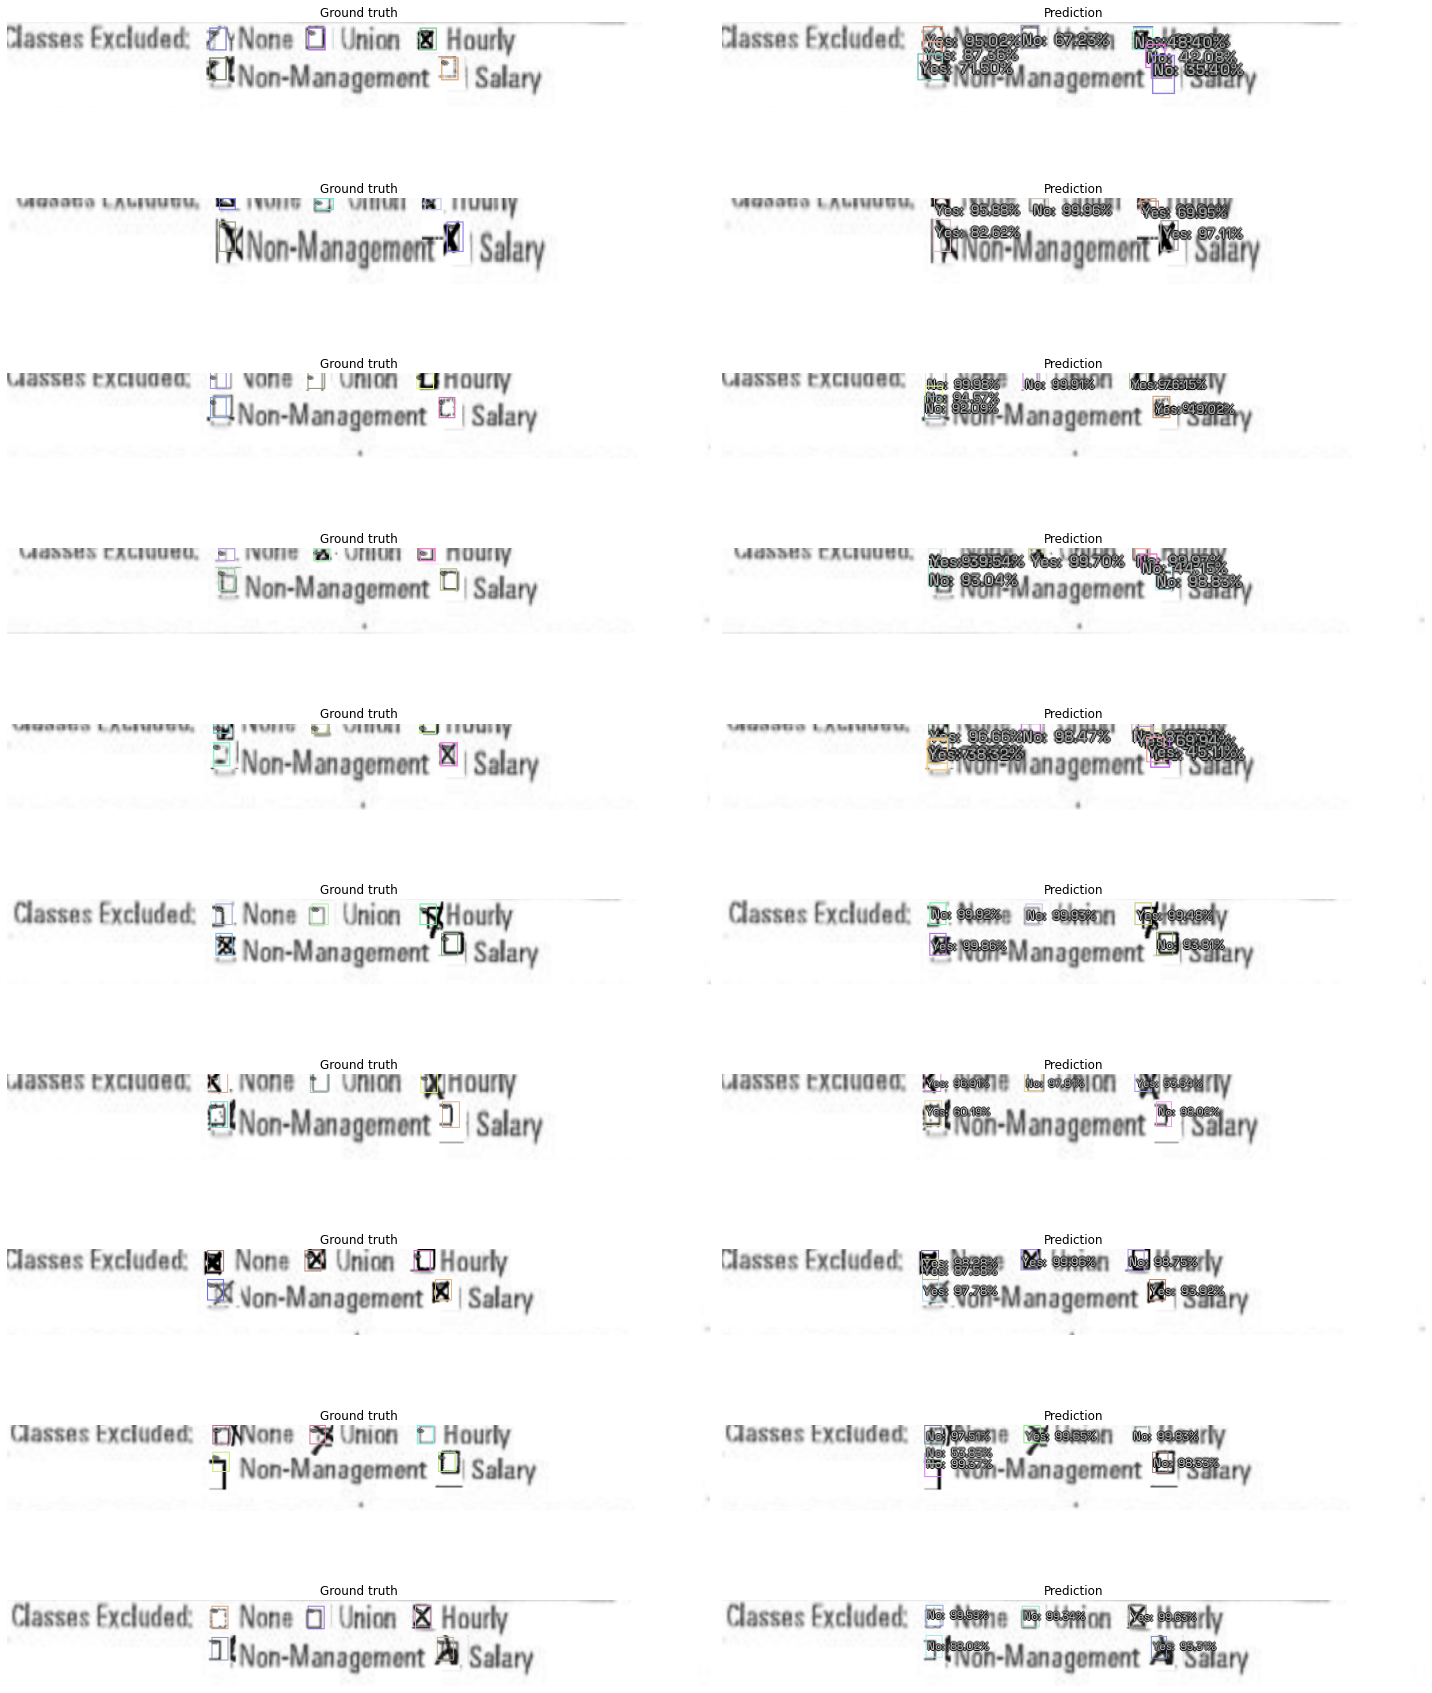

In [39]:
N = 10
show_preds(preds=preds[:N], figsize=(20,int(2.5*N)), ncols=2)

In [46]:
from torch_snippets import load_torch_model_weights_to, save_torch_model_weights_from, makedir
makedir('models')
save_torch_model_weights_from(model, 'models/0.pth')

INFO     - Saved weights of size ~123 MB to models/0.pth | __main__:<module>:3
